


## What kind of problem to solve?

Music Personalize Recommendation, here because of the target column is binary, we take this as a classification problem, in a nutshell, this is a binary classification.

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time, html
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import numba

from sklearn import preprocessing
from collections import defaultdict, Counter, OrderedDict
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

h:\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


init logger instance ...


## Preview
<br/>

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


<br/>
<br/>
<br/>
## Data Clean, Data Type Fix

In [3]:
%%time
data = inp.Input.instance.clean('./data/train.csv')

2018-07-30 21:03:14,173 - trainer.input - INFO [line:30] - Clean start, is_serving: False
2018-07-30 21:03:37,306 - trainer.input - INFO [line:54] - Clean table members.
2018-07-30 21:03:37,852 - trainer.input - INFO [line:65] - Clean table songs.
2018-07-30 21:04:37,575 - trainer.input - INFO [line:84] - Clean take time 0:01:23.401771
Wall time: 1min 24s


### Filter Train Data and Split Train Valid

In [4]:
%%time
tr, vl = inp.Input.instance.split(data=data)

2018-07-30 21:04:38,611 - trainer.input - INFO [line:88] - Split start
2018-07-30 21:04:40,220 - trainer.input - INFO [line:108] - Msno data distribution 
count    30755.000000
mean       239.877028
std        314.130788
min          1.000000
25%         27.000000
50%        128.000000
75%        340.000000
max       5819.000000
dtype: float64

2018-07-30 21:04:40,224 - trainer.input - INFO [line:109] - Filter training data
2018-07-30 21:05:03,103 - trainer.input - INFO [line:117] - Split take time 0:00:24.490401
Wall time: 24.5 s




## Phase 1: Prepare,  Add Columns, Feature Engineering

In [5]:
%%time
inp.Input.instance.prepare(data=data, is_serving=False)

2018-07-30 21:05:03,563 - trainer.input - INFO [line:175] - Prepare start
2018-07-30 21:05:06,659 - trainer.input - INFO [line:188] - 
Do prepare_members
2018-07-30 21:05:12,456 - trainer.input - INFO [line:206] - processing msno_age_catg done, msno_age_num, msno_tenure ...
2018-07-30 21:05:13,779 - trainer.input - INFO [line:222] - processing msno_pos_query, msno_neg_query ...
2018-07-30 21:05:34,604 - trainer.input - INFO [line:141] - source_system_tab count done, take 0:00:05.675325
2018-07-30 21:05:40,727 - trainer.input - INFO [line:141] - source_screen_name count done, take 0:00:05.574319
2018-07-30 21:05:47,751 - trainer.input - INFO [line:141] - source_type count done, take 0:00:06.874394
2018-07-30 21:05:55,527 - trainer.input - INFO [line:141] - language count,mean done, take 0:00:07.612435
2018-07-30 21:06:26,214 - trainer.input - INFO [line:141] - artist_name count,mean done, take 0:00:30.631752
2018-07-30 21:07:02,436 - trainer.input - INFO [line:141] - composer count,mean

## Fit
1. 記住feature狀態, 這裡選擇fit merge過後的fat table, 照理說fit profile table就好(像songs, members), 
雖然fit fat table資料會虛增造成效能慢, 但是有時候會去計算feature出現的頻率, 有些超冷門類別就乾脆transform成0就好, 
這邊從profile資料就無法做到, 這也是選擇fit fat table的原因

In [6]:
%%time
inp.Input.instance.fit('./data/processed/prepared/tr.pkl')

2018-07-30 21:16:45,163 - trainer.input - INFO [line:318] - Fit start
2018-07-30 21:17:22,499 - trainer.input - INFO [line:333] - fit msno ...
2018-07-30 21:17:23,763 - trainer.input - INFO [line:333] - fit song_id ...
2018-07-30 21:17:27,183 - trainer.input - INFO [line:333] - fit source_system_tab ...
2018-07-30 21:17:28,331 - trainer.input - INFO [line:333] - fit source_screen_name ...
2018-07-30 21:17:29,454 - trainer.input - INFO [line:333] - fit source_type ...
2018-07-30 21:17:30,707 - trainer.input - INFO [line:333] - fit city ...
2018-07-30 21:17:31,794 - trainer.input - INFO [line:333] - fit gender ...
2018-07-30 21:17:32,705 - trainer.input - INFO [line:333] - fit registered_via ...
2018-07-30 21:17:33,772 - trainer.input - INFO [line:333] - fit msno_age_catg ...
2018-07-30 21:17:34,691 - trainer.input - INFO [line:333] - fit language ...
2018-07-30 21:17:36,253 - trainer.input - INFO [line:333] - fit song_cc ...
2018-07-30 21:17:37,835 - trainer.input - INFO [line:333] - fi

h:\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-07-30 21:18:49,346 - trainer.input - INFO [line:345] - fit song_yy ...
2018-07-30 21:18:50,149 - trainer.input - INFO [line:345] - fit song_length ...
2018-07-30 21:18:51,094 - trainer.input - INFO [line:345] - fit song_pplrty ...
2018-07-30 21:18:51,892 - trainer.input - INFO [line:345] - fit song_clicks ...
2018-07-30 21:18:53,101 - trainer.input - INFO [line:351] - Fit take time 0:02:07.937318
Wall time: 2min 11s


## Transform
1. Trasnform 所有features為numeric, 這裡選擇transform profile table再去merge增加效能.

In [ ]:
%%time
inp.Input.instance.transform('./data/processed/prepared/tr.pkl')

2018-07-30 21:31:56,600 - trainer.input - INFO [line:361] - Transform start
2018-07-30 21:32:10,008 - trainer.input - INFO [line:392] - transform city, vocab_key: city ...
2018-07-30 21:32:10,046 - trainer.input - INFO [line:518] - transform take time 0:00:00.037002
2018-07-30 21:32:10,065 - trainer.input - INFO [line:392] - transform gender, vocab_key: gender ...
2018-07-30 21:32:10,069 - trainer.input - INFO [line:518] - transform take time 0:00:00.003000
2018-07-30 21:32:10,088 - trainer.input - INFO [line:392] - transform registered_via, vocab_key: registered_via ...
2018-07-30 21:32:10,091 - trainer.input - INFO [line:518] - transform take time 0:00:00.002000
2018-07-30 21:32:10,110 - trainer.input - INFO [line:392] - transform registration_init_time, vocab_key: registration_init_time ...
2018-07-30 21:32:10,113 - trainer.input - INFO [line:518] - transform take time 0:00:00.002000
2018-07-30 21:32:10,114 - trainer.input - INFO [line:392] - transform expiration_date, vocab_key: ex

h:\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2018-07-30 21:32:11,938 - trainer.input - INFO [line:518] - transform take time 0:00:01.787103
2018-07-30 21:32:12,035 - trainer.input - INFO [line:403] - transform msno_neg_query_hist, vocab_key: song_id ...
2018-07-30 21:32:13,694 - trainer.input - INFO [line:518] - transform take time 0:00:01.658095
2018-07-30 21:32:13,810 - trainer.input - INFO [line:403] - transform msno_artist_name_hist, vocab_key: artist_name ...
2018-07-30 21:32:14,783 - trainer.input - INFO [line:518] - transform take time 0:00:00.973055
2018-07-30 21:32:14,808 - trainer.input - INFO [line:403] - transform msno_composer_hist, vocab_key: composer ...
2018-07-30 21:32:16,332 - trainer.input - INFO [line:518] - transform take time 0:00:01.524087
2018-07-30 21:32:16,382 - trainer.input - INFO [line:403] - transform msno_genre_ids_hist, vocab_key: genre_ids ...
2018-07-30 21:32:16,575 - trainer.input - INFO [line:518] - transform take time 0:00:00.192011
2018-07-30 21:32:16,581 - trainer.input - INFO [line:403] - t


## Train

In [5]:
p = app_conf.instance
tf.reset_default_graph()
service.Service.instance.train(model_name='dnn', reset=False)

2018-07-30 14:09:18,796 - trainer.service - INFO [line:21] - Delete job_dir D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm to avoid re-use
2018-07-30 14:09:19,138 - trainer.service - INFO [line:44] - Model Directory: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm
2018-07-30 14:09:19,139 - BestScoreExporter - INFO [line:393] - BestScoreExporter init, last best eval is None
2018-07-30 14:09:19,140 - trainer.service - INFO [line:54] - read train file into memory
2018-07-30 14:09:54,780 - trainer.service - INFO [line:73] - read valid file into memory
2018-07-30 14:10:14,016 - trainer.model - INFO [line:278] - creating a custom Estimator
INFO:tensorflow:Using config: {'_model_dir': 'D:\\Python\\notebook\\ml_specialized\\kkbox/models/kkbox_dnn_adam_max_norm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': gpu_options {
  allow_growth: true
}
graph_options {

2018-07-30 14:27:44,890 - trainer.input - INFO [line:637] - Batch size: 1000
2018-07-30 14:27:44,891 - trainer.input - INFO [line:638] - Epoch count: 1
2018-07-30 14:27:44,892 - trainer.input - INFO [line:639] - Thread count: 8
2018-07-30 14:27:44,893 - trainer.input - INFO [line:640] - Shuffle: False
2018-07-30 14:27:44,894 - trainer.input - INFO [line:641] - ================
2018-07-30 14:27:44,894 - trainer.input - INFO [line:642] - 
INFO:tensorflow:Calling model_fn.
2018-07-30 14:27:45,067 - tensorflow - INFO [line:115] - Calling model_fn.
2018-07-30 14:27:45,069 - trainer.model - INFO [line:144] - mode: eval, is_train: False, use dropout: False
2018-07-30 14:27:45,372 - trainer.model - INFO [line:70] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-07-30 14:27:46,065 - trainer.model - INFO [line:112] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-07-30 14:27:46,073 - trainer.model - INFO [lin

2018-07-30 14:37:29,210 - trainer.input - INFO [line:646] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-07-30 14:38:04,423 - tensorflow - INFO [line:115] - Calling model_fn.
2018-07-30 14:38:04,426 - trainer.model - INFO [line:144] - mode: train, is_train: True, use dropout: False
2018-07-30 14:38:04,835 - trainer.model - INFO [line:70] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-07-30 14:38:05,030 - trainer.model - INFO [line:112] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-07-30 14:38:05,040 - trainer.model - INFO [line:121] - self.context_features: Tensor("context/context_features:0", shape=(?, 9), dtype=float32)
2018-07-30 14:38:05,129 - trainer.model - INFO [line:154] - net: Tensor("dnn/concat:0", shape=(?, 48), dtype=float32)
INFO:tensorflow:Done calling model_fn.
2018-07-30 14:38:12,303 - tensorflow - INFO [line:115] - Done calling model_fn.
INFO:tensorflow:Create 

INFO:tensorflow:Evaluation [492/492]
2018-07-30 15:05:03,260 - tensorflow - INFO [line:115] - Evaluation [492/492]
INFO:tensorflow:Finished evaluation at 2018-07-30-07:05:03
2018-07-30 15:05:03,313 - tensorflow - INFO [line:115] - Finished evaluation at 2018-07-30-07:05:03
INFO:tensorflow:Saving dict for global step 1317: auc = 0.7667876, global_step = 1317, loss = 0.572639
2018-07-30 15:05:03,314 - tensorflow - INFO [line:115] - Saving dict for global step 1317: auc = 0.7667876, global_step = 1317, loss = 0.572639
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1317: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-1317
2018-07-30 15:05:03,319 - tensorflow - INFO [line:115] - Saving 'checkpoint_path' summary for global step 1317: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-1317
2018-07-30 15:05:03,323 - BestScoreExporter - INFO [line:414] - eval_result: {'auc': 0.7667876, 'loss': 0.572639, 'global_

INFO:tensorflow:Saving checkpoints for 1817 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-07-30 15:18:36,506 - tensorflow - INFO [line:115] - Saving checkpoints for 1817 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:global_step/sec: 0.558058
2018-07-30 15:19:00,059 - tensorflow - INFO [line:115] - global_step/sec: 0.558058
INFO:tensorflow:loss = 0.5104281, step = 1817 (179.186 sec)
2018-07-30 15:19:00,082 - tensorflow - INFO [line:115] - loss = 0.5104281, step = 1817 (179.186 sec)
INFO:tensorflow:global_step/sec: 0.661368
2018-07-30 15:21:31,262 - tensorflow - INFO [line:115] - global_step/sec: 0.661368
INFO:tensorflow:loss = 0.49410415, step = 1917 (151.209 sec)
2018-07-30 15:21:31,291 - tensorflow - INFO [line:115] - loss = 0.49410415, step = 1917 (151.209 sec)
INFO:tensorflow:Saving checkpoints for 1958 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\m

INFO:tensorflow:Running local_init_op.
2018-07-30 15:32:49,263 - tensorflow - INFO [line:115] - Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2018-07-30 15:32:49,308 - tensorflow - INFO [line:115] - Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1958 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-07-30 15:32:51,995 - tensorflow - INFO [line:115] - Saving checkpoints for 1958 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:loss = 0.49133375, step = 1958
2018-07-30 15:33:05,349 - tensorflow - INFO [line:115] - loss = 0.49133375, step = 1958
INFO:tensorflow:global_step/sec: 0.715528
2018-07-30 15:35:25,099 - tensorflow - INFO [line:115] - global_step/sec: 0.715528
INFO:tensorflow:loss = 0.5060157, step = 2058 (141.501 sec)
2018-07-30 15:35:26,852 - tensorflow - INFO [line:115] - loss = 0.5060157, step = 2058 (141.501 sec)
INFO:tensorflow:global_ste

2018-07-30 15:59:36,852 - trainer.input - INFO [line:638] - Epoch count: 1
2018-07-30 15:59:36,853 - trainer.input - INFO [line:639] - Thread count: 8
2018-07-30 15:59:36,854 - trainer.input - INFO [line:640] - Shuffle: True
2018-07-30 15:59:36,856 - trainer.input - INFO [line:641] - ================
2018-07-30 15:59:36,857 - trainer.input - INFO [line:642] - 
2018-07-30 15:59:36,858 - trainer.input - INFO [line:646] - shuffle data manually.
INFO:tensorflow:Calling model_fn.
2018-07-30 16:00:11,741 - tensorflow - INFO [line:115] - Calling model_fn.
2018-07-30 16:00:11,748 - trainer.model - INFO [line:144] - mode: train, is_train: True, use dropout: False
2018-07-30 16:00:17,999 - trainer.model - INFO [line:70] - self.members_feature: Tensor("members/members_feature:0", shape=(?, 175), dtype=float32)
2018-07-30 16:00:18,200 - trainer.model - INFO [line:112] - self.songs_feature: Tensor("songs/songs_feature:0", shape=(?, 120), dtype=float32)
2018-07-30 16:00:18,209 - trainer.model - INFO

2018-07-30 16:24:04,719 - tensorflow - INFO [line:115] - Evaluation [343/492]
INFO:tensorflow:Evaluation [392/492]
2018-07-30 16:25:03,646 - tensorflow - INFO [line:115] - Evaluation [392/492]
INFO:tensorflow:Evaluation [441/492]
2018-07-30 16:25:58,020 - tensorflow - INFO [line:115] - Evaluation [441/492]
INFO:tensorflow:Evaluation [490/492]
2018-07-30 16:26:52,073 - tensorflow - INFO [line:115] - Evaluation [490/492]
INFO:tensorflow:Evaluation [492/492]
2018-07-30 16:26:54,633 - tensorflow - INFO [line:115] - Evaluation [492/492]
INFO:tensorflow:Finished evaluation at 2018-07-30-08:26:54
2018-07-30 16:26:54,690 - tensorflow - INFO [line:115] - Finished evaluation at 2018-07-30-08:26:54
INFO:tensorflow:Saving dict for global step 3278: auc = 0.7749478, global_step = 3278, loss = 0.5721955
2018-07-30 16:26:54,693 - tensorflow - INFO [line:115] - Saving dict for global step 3278: auc = 0.7749478, global_step = 3278, loss = 0.5721955
INFO:tensorflow:Saving 'checkpoint_path' summary for g

INFO:tensorflow:loss = 0.4920144, step = 3578 (168.012 sec)
2018-07-30 16:35:59,553 - tensorflow - INFO [line:115] - loss = 0.4920144, step = 3578 (168.012 sec)
INFO:tensorflow:global_step/sec: 0.646453
2018-07-30 16:38:32,529 - tensorflow - INFO [line:115] - global_step/sec: 0.646453
INFO:tensorflow:loss = 0.47235852, step = 3678 (153.058 sec)
2018-07-30 16:38:32,613 - tensorflow - INFO [line:115] - loss = 0.47235852, step = 3678 (153.058 sec)
INFO:tensorflow:Saving checkpoints for 3778 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
2018-07-30 16:41:22,615 - tensorflow - INFO [line:115] - Saving checkpoints for 3778 into D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt.
INFO:tensorflow:global_step/sec: 0.458059
2018-07-30 16:42:10,796 - tensorflow - INFO [line:115] - global_step/sec: 0.458059
INFO:tensorflow:loss = 0.47596598, step = 3778 (218.311 sec)
2018-07-30 16:42:10,921 - tensorflow - INFO [line:115] - los

INFO:tensorflow:Signatures INCLUDED in export for Eval: None
2018-07-30 16:54:09,605 - tensorflow - INFO [line:115] - Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-3864
2018-07-30 16:54:09,683 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\model.ckpt-3864
INFO:tensorflow:Assets added to graph.
2018-07-30 16:54:09,768 - tensorflow - INFO [line:115] - Assets added to graph.
INFO:tensorflow:No assets to write.
2018-07-30 16:54:09,769 - tensorflow - INFO [line:115] - No assets to write.
INFO:tensorflow:SavedModel written to: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max_norm\export\estimator\temp-b'1532940847'\saved_model.pb
2018-07-30 16:54:10,283 - tensorflow - INFO [line:115] - SavedModel written to: D:\Python\notebook\ml_specialized\kkbox/models/kkbox_dnn_adam_max

INFO:tensorflow:Evaluation [147/492]
2018-07-30 17:12:16,452 - tensorflow - INFO [line:115] - Evaluation [147/492]
INFO:tensorflow:Evaluation [196/492]
2018-07-30 17:13:13,691 - tensorflow - INFO [line:115] - Evaluation [196/492]
INFO:tensorflow:Evaluation [245/492]
2018-07-30 17:14:11,944 - tensorflow - INFO [line:115] - Evaluation [245/492]
INFO:tensorflow:Evaluation [294/492]
2018-07-30 17:15:11,277 - tensorflow - INFO [line:115] - Evaluation [294/492]
INFO:tensorflow:Evaluation [343/492]
2018-07-30 17:16:07,821 - tensorflow - INFO [line:115] - Evaluation [343/492]
INFO:tensorflow:Evaluation [392/492]
2018-07-30 17:17:04,633 - tensorflow - INFO [line:115] - Evaluation [392/492]
INFO:tensorflow:Evaluation [441/492]
2018-07-30 17:18:02,537 - tensorflow - INFO [line:115] - Evaluation [441/492]
INFO:tensorflow:Evaluation [490/492]
2018-07-30 17:18:59,903 - tensorflow - INFO [line:115] - Evaluation [490/492]
INFO:tensorflow:Evaluation [492/492]
2018-07-30 17:19:02,477 - tensorflow - INFO

In [ ]:
p = app_conf.instance
tf.reset_default_graph()
service.Service.instance.train(model_name='neu_mf', reset=False)

In [40]:
df = pd.DataFrame({'composer_list': data.composer_list.dropna().values, 
                   'len': data.composer_list.dropna().map(len).values})
print(df.head())
df.loc[df.len.idxmax()].composer_list

                               composer_list  len
0                     (Dan Smith, Mark Crew)    2
1    (N. Jones、W. Adams、J. Lordan、D. Ingle,)    1
2                           (Kwadwo Donkoh,)    1
3  (Brett Young, Justin Ebach, Kelly Archer)    3
4                 (Adnan Khan, Sidney Selby)    2


('1011,Kenny Rogers,Roger Bowling',
 '139,G.E.M.鄧紫棋,Kaci Brown',
 '139,Oldies 101,William Mickey Stevenson',
 '947,Music-Themes,,,-1\nXPGjUo/wPuYRoFYVB25kQ9TX5zP6Izcllmez7PPXB4I=,241673,465,Janet Jackson,Janet Jackson',
 'Aaron Gillespie',
 'Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels',
 'Charles Twong',
 'Chauncey Hollis,,52\n9sYIx+29PAF7BOk4loE2xYPSdeg7zmpGwbbInOyVhVo=,172849,921,Randy Newman,Axwell',
 'Christopher Dudley,,52\nOi7rlCO6VbZZ5UqcSyg8vDVvFjMQYeV+iYAbxB6LSd0=,169227,2122,Sarah Vaughan,R. Turk',
 'D

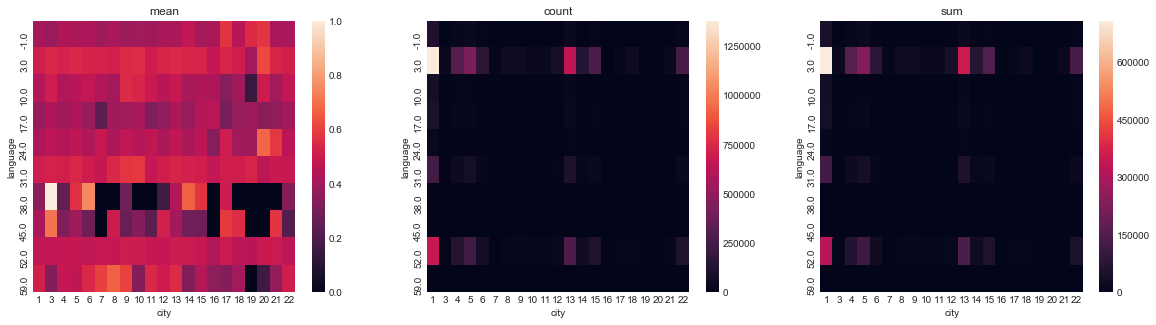

In [13]:
utils_nb.heatmap(data, 'language', 'city', annot=False)

## Age and Genres

In [ ]:
%%time
multi_catg_heatmap('genre_list', 'age')

## Popular Artist
-  We evaluate the popularity of the artist by calculate `mean * sum` by target label, value of target belong to [0, 1], so `sum` can represent the popularity but, maybe there are many 0 in the votes, so multiple the `mean` to get more fair result
-  According the boxplot, the popularity distribution is very skew, most of them close to zero, this is expected result, for this situation, we will add some features like the interaction between `[target + artist], [target + language]`..., etc.

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

<br/>
<br/>
<br/>
## Filter some rows

1. First we filter out the majority and the minority => [100 <= msno.group.size <= 1000], we don't want some majority to dominate the model
2. Insure that records of target = 1 greater than 35, we want 30% in valid data records of target = 1 greater than 10
    ```
    35 * 0.3 = 10.5
    ```

In [ ]:
""" Use DataFrameGroupBy.filter will be greate !!!"""
# msno_grp = data.groupby('msno')
# msno_grp.size().describe()

# df = pd.DataFrame({'size': msno_grp.size(), 'sum': msno_grp.target.sum()})

# data = data[data.msno.isin(df.query('sum >= 35 and 100 <= size and size <= 1000').index)]
# print(data.shape)
# print(data.target.value_counts())

In [ ]:
enc = utils.CounterEncoder()
enc.partial_fit( train.source_system_tab )

In [ ]:
np.linalg.norm([1, 2, 3] / np.linalg.norm([1, 2, 3]))


In [ ]:
feat = 'source_system_tab'
feat_dummies = pd.get_dummies(data[feat])
feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
feat_dummies.head()
feat_dummies['msno'] = data['msno'].values
feat_dummies = feat_dummies.groupby('msno').mean()
feat_dummies['msno'] = feat_dummies.index
a = members.merge(feat_dummies, on='msno', how='left')
a.head()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

## Test

In [178]:
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

tf.reset_default_graph()
with tf.Graph().as_default():
    norm = tf.sequence_mask([1, 2, 3], dtype=tf.float32)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print( sess.run(norm) )

[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]
